In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import joblib
import os
import seaborn as sns

In [3]:
# Configure plots
import seaborn as sns
sns.set_theme()
%config InlineBackend.figure_format = 'retina'

In [4]:
# 1. Load Forecast Data
# ======================
print("Loading forecast data from Task 3...")
forecasts = {}
assets = ['TSLA', 'BND', 'SPY']

for asset in assets:
    forecast_path = f"forecasts/{asset}_forecast.csv"
    forecasts[asset] = pd.read_csv(forecast_path, index_col='Date', parse_dates=True)['Forecast']
    print(f"{asset} forecast shape: {forecasts[asset].shape}")

# Combine forecasts into portfolio
portfolio = pd.DataFrame(forecasts)
portfolio = portfolio.asfreq('B')  # Align to business days

Loading forecast data from Task 3...
TSLA forecast shape: (126,)
BND forecast shape: (126,)
SPY forecast shape: (126,)


In [5]:
# 2. Calculate Financial Metrics
# ======================
# Daily returns
returns = portfolio.pct_change().dropna()

# Annualized metrics
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

print("\nAnnualized Expected Returns:")
print(expected_returns.round(4))

print("\nAnnualized Covariance Matrix:")
print(cov_matrix.round(4))


Annualized Expected Returns:
TSLA    0.1233
BND     0.0091
SPY     0.0673
dtype: float64

Annualized Covariance Matrix:
        TSLA  BND  SPY
TSLA  0.0004 -0.0  0.0
BND  -0.0000  0.0  0.0
SPY   0.0000  0.0  0.0


In [7]:
# 3. Portfolio Optimization
# ======================
def sharpe_ratio(weights, er=expected_returns, cov=cov_matrix, risk_free=0.02):
    """Calculate negative Sharpe ratio for minimization"""
    port_return = np.dot(weights, er)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return -(port_return - risk_free) / port_vol

# Constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(3))

# Initial guess (equal weights)
init_weights = np.array([1/3, 1/3, 1/3])

# Optimize
result = minimize(sharpe_ratio, init_weights,
                  method='SLSQP', bounds=bounds,
                  constraints=constraints)

optimal_weights = result.x
print("\nOptimization Results:")
print(f"TSLA: {optimal_weights[0]:.2%}")
print(f"BND: {optimal_weights[1]:.2%}")
print(f"SPY: {optimal_weights[2]:.2%}")


Optimization Results:
TSLA: 0.00%
BND: 0.00%
SPY: 100.00%


In [8]:
# 4. Portfolio Analysis
# ======================
# Calculate portfolio metrics
port_return = np.dot(optimal_weights, expected_returns)
port_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
sharpe = (port_return - 0.02) / port_vol

# Value at Risk (Historical Simulation)
returns_tsla = returns['TSLA']
var_95 = np.percentile(returns_tsla, 5)

print("\nPortfolio Metrics:")
print(f"Expected Annual Return: {port_return:.2%}")
print(f"Annual Volatility: {port_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"TSLA 95% Daily VaR: {var_95:.2%}")



Portfolio Metrics:
Expected Annual Return: 6.73%
Annual Volatility: 0.08%
Sharpe Ratio: 58.44
TSLA 95% Daily VaR: -0.13%


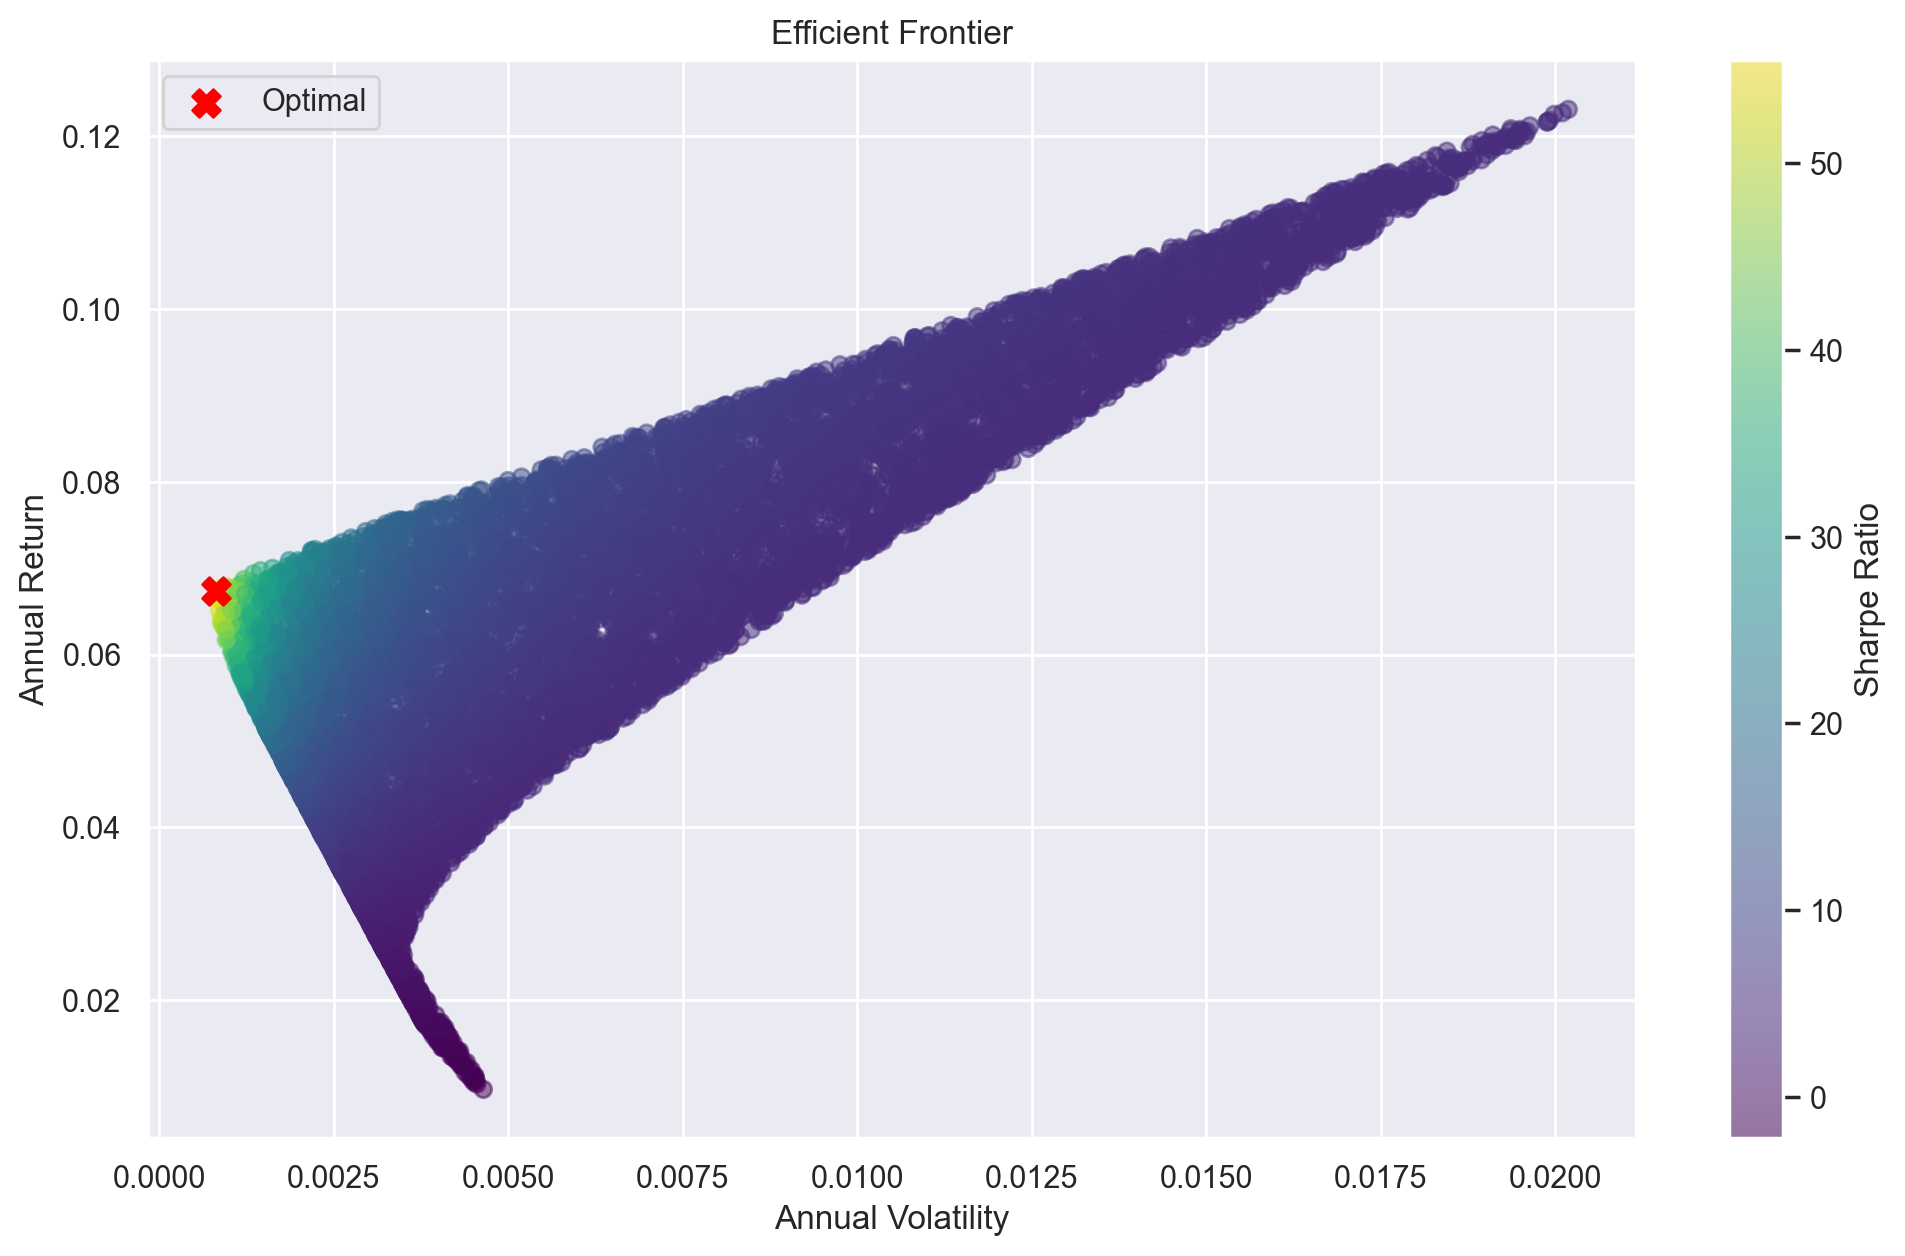

In [10]:
# 5. Visualizations
# ======================
# Efficient Frontier Plot
plt.figure(figsize=(12, 7))
n_portfolios = 10000
results = np.zeros((3, n_portfolios))

np.random.seed(42)
for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(3))
    pret = np.dot(weights, expected_returns)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = pret
    results[1,i] = pvol
    results[2,i] = (pret - 0.02) / pvol

plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(port_vol, port_return, c='red', s=100, marker='X', label='Optimal')
plt.title('Efficient Frontier')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.legend()
plt.show()

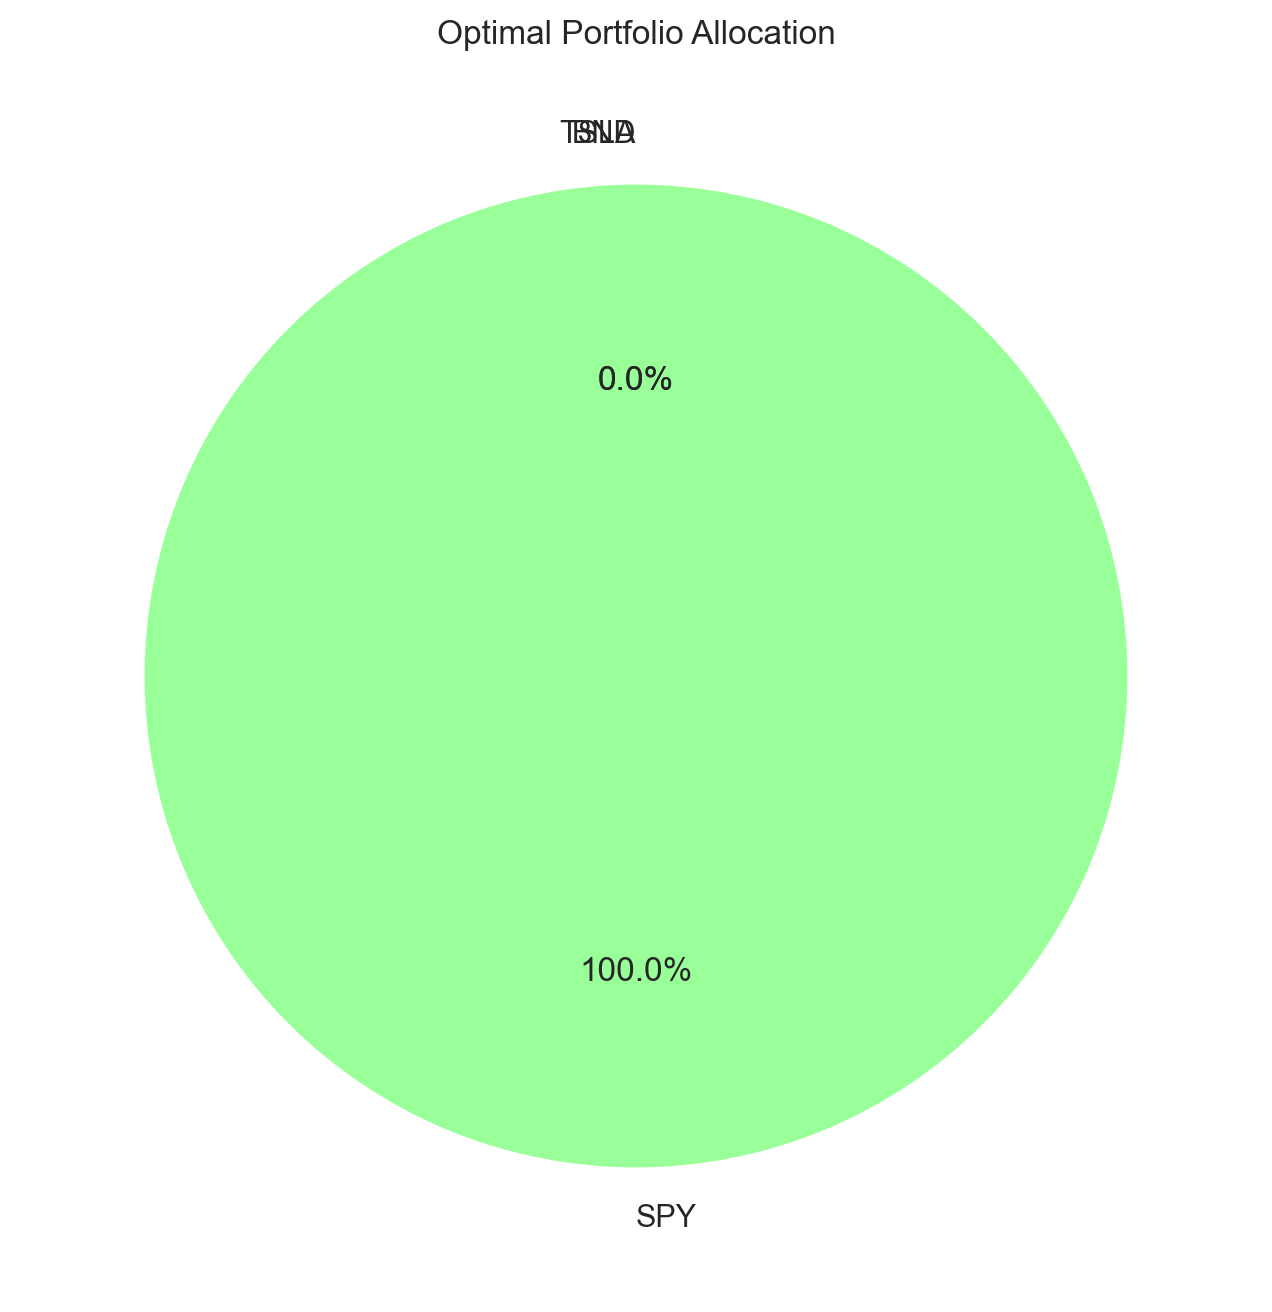

In [12]:
# Pie Chart of Optimal Allocation
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, 
        labels=assets,
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff','#99ff99'],
        startangle=90)
plt.title('Optimal Portfolio Allocation')
plt.show()

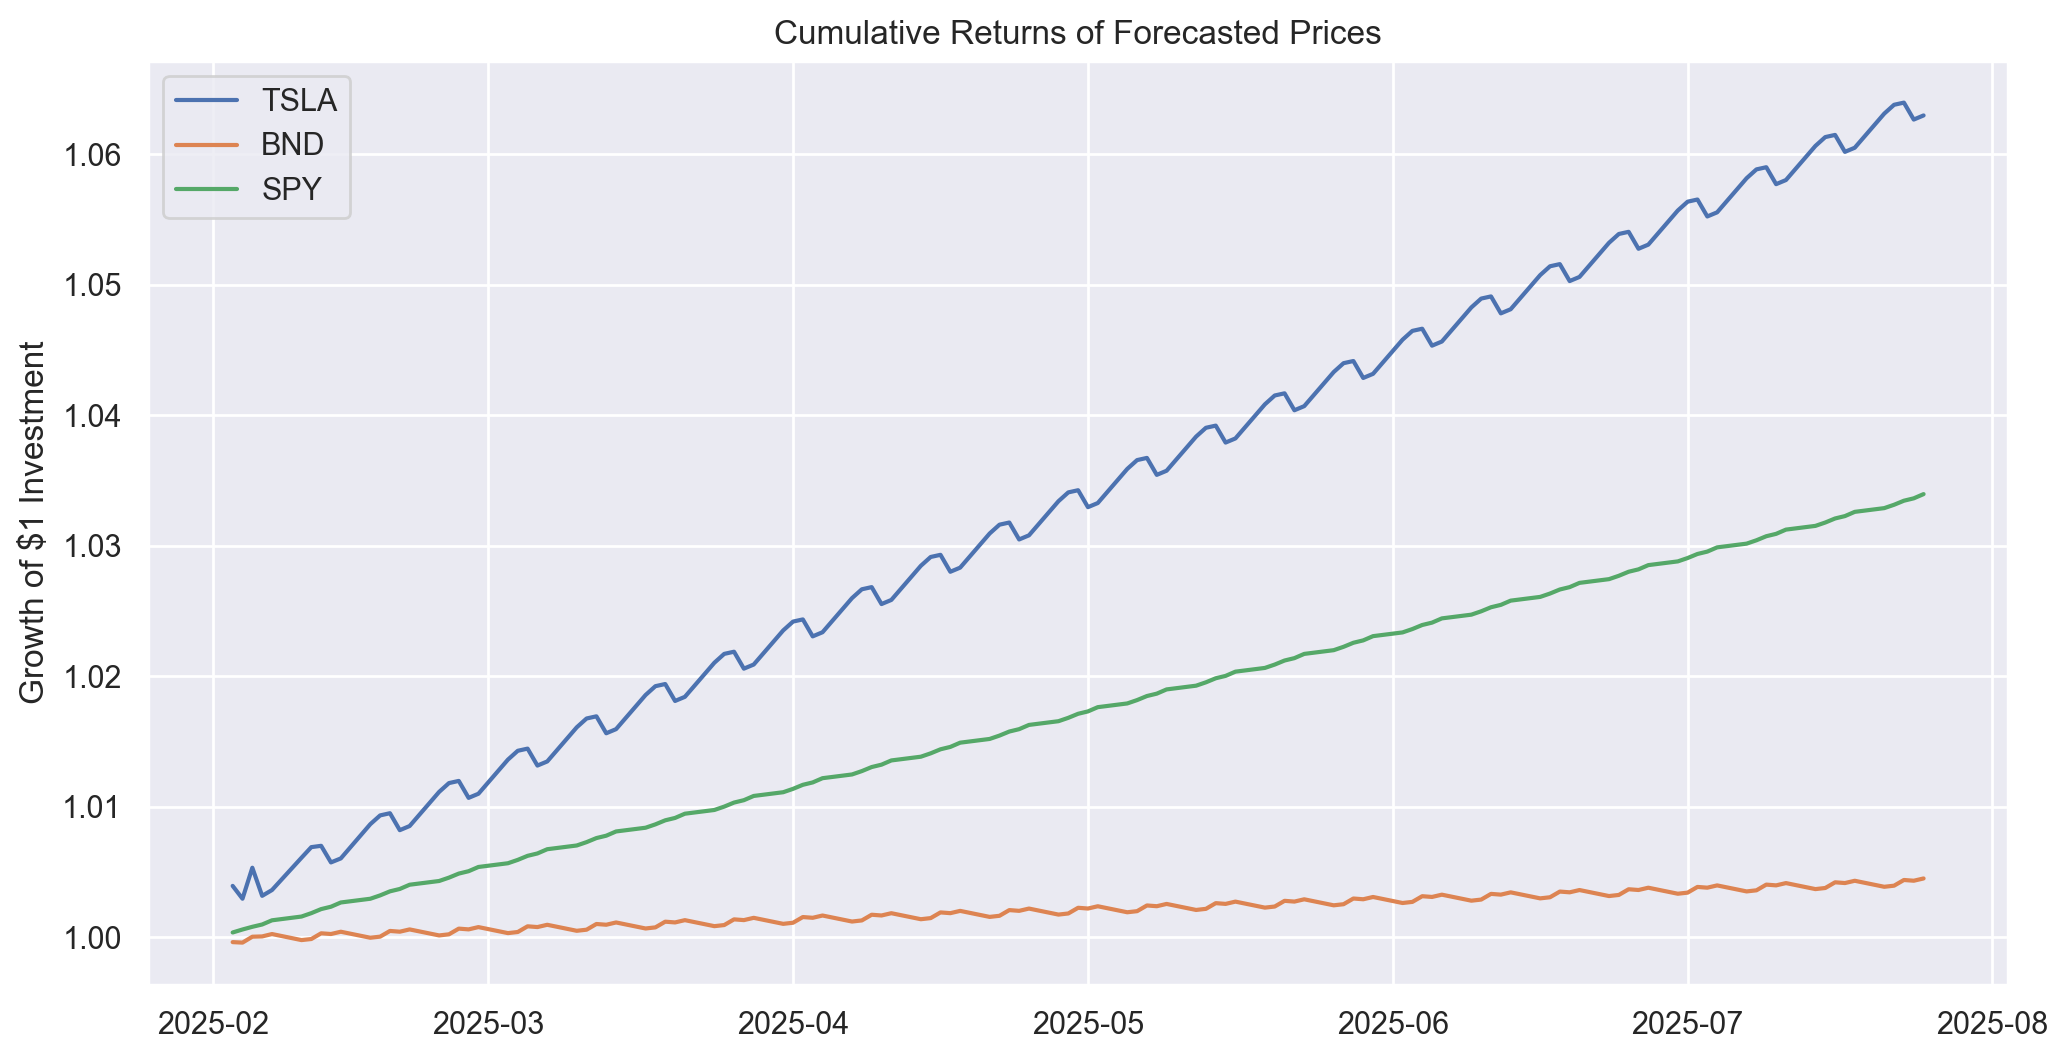

In [14]:
# Cumulative Returns Plot
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(12, 6))
for asset in assets:
    plt.plot(cumulative_returns[asset], label=asset)

plt.title('Cumulative Returns of Forecasted Prices')
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Save parameters
with open("portfolio_metrics/optimization_report.txt", "w") as f:
    f.write("GMF Investments Portfolio Optimization Report\n")
    f.write("=============================================\n\n")
    f.write(f"Optimal Weights:\n")
    for asset, weight in zip(assets, optimal_weights):
        f.write(f"- {asset}: {weight:.2%}\n")
    f.write(f"\nKey Metrics:\n")
    f.write(f"- Expected Annual Return: {port_return:.2%}\n")
    f.write(f"- Annual Volatility: {port_vol:.2%}\n")
    f.write(f"- Sharpe Ratio: {sharpe:.2f}\n")
    f.write(f"- TSLA 95% Daily VaR: {var_95:.2%}\n")